# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import spacy
import re
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head(15)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [5]:
print(data.isnull().sum())

Unnamed: 0    0
text          0
toxic         0
dtype: int64


Пропущенных значений нет

In [6]:
print (data['toxic'].unique())

[0 1]


Посторонних значений в стобце с целевым признаком нет.

In [7]:
data_toxic= data['toxic'].value_counts()

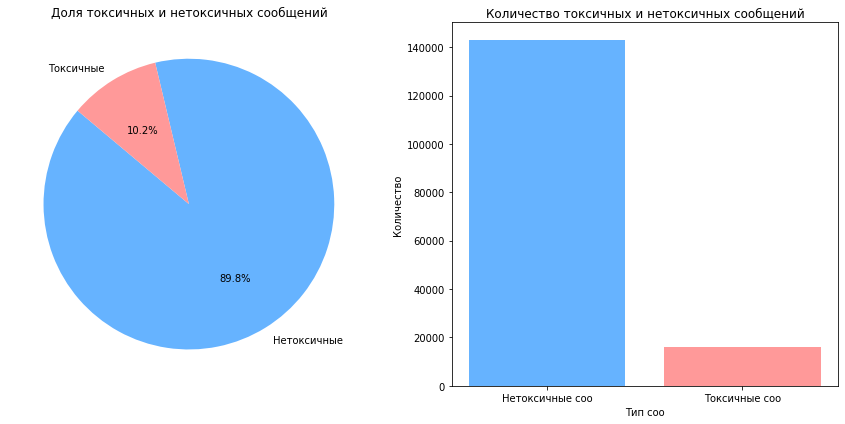

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(data_toxic, labels=['Нетоксичные', 'Токсичные'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
axes[0].set_title('Доля токсичных и нетоксичных сообщений')


axes[1].bar(data_toxic.index, data_toxic.values, color=['#66b3ff','#ff9999'])
axes[1].set_xticks(data_toxic.index)
axes[1].set_xticklabels(['Нетоксичные соо', 'Токсичные соо'])
axes[1].set_title('Количество токсичных и нетоксичных сообщений')
axes[1].set_xlabel('Тип соо')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

Имеется датафрейм с текстом сообщений и определением, является ли сообщение токсичным или нет. В столбце toxic только два значения: 0 и 1. На круговой и столбчатых диаграммах видно преобладание нетоксичных сообщений (примерно 9 к 1), из-за чего возникает несбалансированность данных.

## Обучение

In [9]:
X = data['text']
y = data['toxic']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

Функция для лемматизации текста и удаления неалфавитных символов

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
def lemmatize_text(text):
    text = text.lower()
    doc = nlp(text)
    lemm_text = ' '.join([token.lemma_ for token in doc if token.is_alpha])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

In [13]:
tqdm.pandas()
X_train = X_train.progress_apply(lemmatize_text)
X_test = X_test.progress_apply(lemmatize_text)

100%|██████████| 31859/31859 [09:53<00:00, 53.64it/s]


Векторизирую текст с помощью TF-IDF

Преобразую тексты в TF-IDF признаки

In [14]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
scores_data = []

In [16]:
classificator = LogisticRegression()

F1 на логистической регрессии без балансировки классов:

In [17]:
train_f1 = cross_val_score(classificator, X_train_tfidf, y_train, cv=5, scoring='f1').mean()
print('F1 на CV', train_f1)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1 на CV 0.7370708724684896


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 на кросс-валидации для лог регрессии с балансированными классами

In [18]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, X_train_tfidf, y_train, cv=5, scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1 на CV с балансированными классами 0.7264026674442485


Функция для подбора гиперпараметров для логистической регрессии

In [19]:
def hyperparameters(classifier, param_grid, X, y):
    clf = GridSearchCV(classifier, param_grid, scoring='f1', cv=5)
    clf.fit(X, y)
    return clf.best_params_, clf.best_score_

In [20]:
hyperparams = [{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}]
best_params, best_cv_f1 = hyperparameters(LogisticRegression(), hyperparams, X_train_tfidf, y_train)
print("Лучшие параметры, найденные на этапе разработки:", best_params)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшие параметры, найденные на этапе разработки: {'C': 10, 'class_weight': None, 'solver': 'lbfgs'}


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
classificator = LogisticRegression()
classificator.set_params(**best_params)
classificator.fit(X_train_tfidf, y_train)
test_f1_LR = f1_score(y_test, classificator.predict(X_test_tfidf))
roc_auc_LR = roc_auc_score(y_test, classificator.predict_proba(X_test_tfidf)[:, 1])

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
results = pd.DataFrame({
    'Модель': ['LogisticRegression Улучшенная'],
    'F1 на CV': [best_cv_f1],
    'F1 на тесте': [test_f1_LR],
    'AUC-ROC': [roc_auc_LR]
})

In [23]:
display(results)

,Модель,F1 на CV,F1 на тесте,AUC-ROC
0,LogisticRegression Улучшенная,0.771417,0.781605,0.966702


## Выводы

В предобработке данных сделана очистка данных /datasets/toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак. 

Текст векторизирован с использованием TF-IDF с максимальным числом признаков в 10 000. 

F1 на логистической регрессии с кроссвалидацией без балансировки классов: 0.7370708724684896

F1 на логистической регрессии с кроссвалидацией с балансом классов: 0.7264026674442485

F1 на CV с уменьшением примеров нормальных комментариев: 0.8893635741968108

Лучшие параметры, найденные на этапе разработки: {'C': 10, 'class_weight': None, 'solver': 'lbfgs'}

Лучший результат на тестовых данных: 0.781605